In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from surprise import SVD, Dataset, Reader
import datetime

### Load data

In [2]:
df = pd.read_csv("../data/data_cleaned.csv", low_memory=False)
df.head()

,Runner ID,First Name,Surname,Nat.,Gender,Age,Age Group,Cat,YOB,Race Count,...,Cat. Rank,Finish Percentage,Performance Ratio,Distance/Time,Distance KM,Terrain,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h
0,146799,David,Papineau,CAN,M,42.0,40-49,M40,1968.0,0,...,1.0,0.02,1.000000,50km,50.0,road,13911.0,NaN,278.22,12.939
1,35382,Hassan,Lotfi-Pour,CAN,M,42.0,40-49,M40,1968.0,0,...,2.0,0.04,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
2,11991,Ryne,Melcher,CAN,M,31.0,30-39,M23,1979.0,0,...,1.0,0.05,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
3,37142,Gary,Robbins,CAN,M,34.0,30-39,M23,1976.0,0,...,2.0,0.07,0.966377,50km,50.0,road,14395.0,NaN,287.90,12.504
4,746071,Rian,O'Maol Chonaire,CAN,M,33.0,30-39,M23,1977.0,0,...,3.0,0.09,0.920040,50km,50.0,road,15120.0,NaN,302.40,11.905


### Aggregated stats
Calculates runners aggregated and some average stats of their races prior to their current race. Running in parallel due to size of dataset

In [75]:
# Only looking at distance based events initially 
df_clean = df[df['Event Type']=='Distance']
#df_clean = df_clean[pd.to_datetime(df_clean['Date'])>=("2024-01-01")]
df_clean.head()

,Runner ID,First Name,Surname,Nat.,Gender,Age,Age Group,Cat,YOB,Race Count,...,Cat. Rank,Finish Percentage,Performance Ratio,Distance/Time,Distance KM,Terrain,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h
6114246,2152651,Shu-Bin (金树滨),Jin,CHN,M,NaN,Unknown,Unknown,NaN,0,...,1.0,0.02,1.000000,53km,53.0,road,19665.0,NaN,371.037736,9.703
6114247,1546671,Xin-Hua (钟新华),Zhong,CHN,M,43.0,40-49,M40,1981.0,3,...,1.0,0.03,0.928953,53km,53.0,road,21169.0,NaN,399.415094,9.013
6114248,1564224,Xin-Hui (王心晖),Wang,CHN,M,42.0,40-49,M40,1982.0,1,...,2.0,0.05,0.803506,53km,53.0,road,24474.0,NaN,461.773585,7.796
6114249,2153509,Qi-Tao (余琦涛),Yu,CHN,M,NaN,Unknown,Unknown,NaN,0,...,2.0,0.06,0.764937,53km,53.0,road,25708.0,NaN,485.056604,7.422
6114250,2153079,Wei-Wei (陶维维),Tao,CHN,F,NaN,Unknown,Unknown,NaN,0,...,3.0,0.08,0.761442,53km,53.0,road,25826.0,NaN,487.283019,7.388


In [ ]:
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm  # Use the notebook version of tqdm

def aggregate_runner_data(runner_group):
    runner_group = runner_group.sort_values('Date')
    aggregated_data = []
    
    for i, (_, current_race) in enumerate(runner_group.iterrows()):
        current_date = current_race['Date']
        prior_events = runner_group.iloc[:i]
        
        if prior_events.empty:
            aggregates = pd.Series({
                'Avg_Performance_Ratio': np.nan,
                'Avg_Finish_Percentage': np.nan,
                'Total_Races': 0,
                'Total_Distance': 0,
                'Preferred_Terrain': 'Unknown',
                'Avg_Speed': np.nan,
                'Days_Since_Last_Race': np.nan,
                'Is_First_Race': True
            })
        else:
            aggregates = pd.Series({
                'Avg_Performance_Ratio': prior_events['Performance Ratio'].mean(),
                'Avg_Finish_Percentage': prior_events['Finish Percentage'].mean(),
                'Total_Races': len(prior_events),
                'Total_Distance': prior_events['Distance KM'].sum(),
                'Preferred_Terrain': prior_events['Terrain'].mode().iloc[0] if not prior_events['Terrain'].mode().empty else 'Unknown',
                'Avg_Speed': prior_events['Avg.Speed km/h'].mean(),
                'Days_Since_Last_Race': (current_date - prior_events['Date'].iloc[-1]).days,
                'Is_First_Race': False
            })
        
        aggregated_data.append(pd.concat([current_race, aggregates]))
    
    return pd.DataFrame(aggregated_data)

def process_runner_group(group):
    return aggregate_runner_data(group)

def concat_in_chunks(dataframes, chunk_size=100):
    concatenated = pd.DataFrame()
    for i in range(0, len(dataframes), chunk_size):
        chunk = pd.concat(dataframes[i:i+chunk_size], ignore_index=True)
        concatenated = pd.concat([concatenated, chunk], ignore_index=True)
        print(f"Concatenated {i+chunk_size} results...")  # Debug print
    return concatenated

def process_dataset_parallel(data, n_jobs=None):
    if n_jobs is None:
        n_jobs = cpu_count()

    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date')

    grouped = [group for _, group in data.groupby('Runner ID')]

    results = []
    with tqdm(total=len(grouped), desc="Processing Groups") as pbar:
        if n_jobs == 1:
            # Single-process mode for debugging
            for group in grouped:
                result = process_runner_group(group)
                results.append(result)
                pbar.update()
        else:
            # Multiprocessing mode
            with Pool(n_jobs) as pool:
                for result in pool.imap_unordered(process_runner_group, grouped):
                    results.append(result)
                    pbar.update()
                pool.close()
                pool.join()

    # Filter out None and empty DataFrames
    valid_results = [res for res in results if res is not None and not res.empty]
    print(f"Number of valid results: {len(valid_results)}")

    # Concatenate in chunks to avoid memory issues
    processed_data = concat_in_chunks(valid_results, chunk_size=10000)
    
    return processed_data

data = df_clean

# Process the data
processed_data = process_dataset_parallel(data, n_jobs=1)
print("Data processed, here is the head of the dataframe:")
print(processed_data.head())

### Random Forest

In [26]:
features = df_clean.groupby('Runner ID').agg(
    average_time=('Time Seconds Finish', 'mean'),
    min_time=('Time Seconds Finish', 'min'),
    max_time=('Time Seconds Finish', 'max'),
    count_races=('Time Seconds Finish', 'count'),
    avg_percentile=('Finish Percentage', 'mean'),
    max_percentile=('Finish Percentage', 'max'),
    min_percentile=('Finish Percentage', 'min'),
    avg_speed=('Average Speed', 'mean'),
    max_speed=('Average Speed', 'max'),
    min_speed=('Average Speed', 'min'),
    #race_difficulty=('Normalised Difficulty Score', 'mean'),
    #weighted_performance=('Weighted Performance', 'mean')
).reset_index()

features.head()

,Runner ID,average_time,min_time,max_time,count_races,avg_percentile,max_percentile,min_percentile,avg_speed,max_speed,min_speed
0,1,29430.800000,22817.0,42286.0,5,0.914000,0.97,0.84,577.214365,741.859649,456.34
1,1000005,57722.666667,51868.0,64375.0,3,0.683333,0.81,0.49,712.701294,858.333333,569.25
2,1000007,51323.000000,51323.0,51323.0,1,0.840000,0.84,0.84,603.800000,603.800000,603.80
3,1000009,28456.500000,13052.0,71031.0,4,0.070000,0.15,0.01,386.380340,689.621359,261.04
4,1000016,28595.000000,28595.0,28595.0,1,0.990000,0.99,0.99,571.900000,571.900000,571.90


In [34]:
data = df_clean

# Function to aggregate runner data
def aggregate_runner_data(group):
    return pd.Series({
        'Avg_Performance_Ratio': group['Performance Ratio'].mean(),
        'Avg_Finish_Percentage': group['Finish Percentage'].mean(),
        'Total_Races': len(group),
        'Total_Distance': group['Distance KM'].sum(),
        'Preferred_Terrain': group['Terrain'].mode().iloc[0],
        'Avg_Speed': group['Avg.Speed km/h'].mean()
    })

# Aggregate runner data
runner_data = data.groupby('Runner ID').apply(aggregate_runner_data).reset_index()

# Merge aggregated data back with original data
merged_data = pd.merge(data, runner_data, on='Runner ID', suffixes=('', '_history'))

# Select features and target
features = [
    'Distance KM', 'Elevation Gain', 'Terrain', 'Total Finishers', 
    'Avg_Performance_Ratio', 'Avg_Finish_Percentage',
    'Total_Races', 'Total_Distance', 'Preferred_Terrain',
    'Avg_Speed', 'Age', 'Gender'
]
target = 'Time Seconds Finish'

# Remove rows with NaN values in features or target
merged_data_clean = merged_data.dropna(subset=features + [target])

In [35]:
# Prepare the features and target
X = merged_data_clean[features]
y = merged_data_clean[target]

# Handle missing values
X = X.fillna({
    'Avg_Performance_Ratio': X['Avg_Performance_Ratio'].mean(),
    'Avg_Finish_Percentage': X['Avg_Finish_Percentage'].mean(),
    'Total_Races': 0,
    'Total_Distance': 0,
    'Preferred_Terrain': 'Unknown',
    'Avg_Speed': X['Avg_Speed'].mean(),
    'Age': X['Age'].median()
})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = [
    'Distance KM', 'Elevation Gain', 'Total Finishers', #'Normalised Difficulty Score',
    'Avg_Performance_Ratio', 'Avg_Finish_Percentage', 'Total_Races', 'Total_Distance',
    #'Avg_Normalised_Difficulty', 
    'Avg_Speed', 'Age'
]
categorical_features = ['Terrain', 'Preferred_Terrain', 'Gender']

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline with preprocessor and random forest
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [36]:
# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
 
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Absolute Error: 2626.436050567125
Mean Squared Error: 24504329.413211934
R-squared Score: 0.9842156920676882


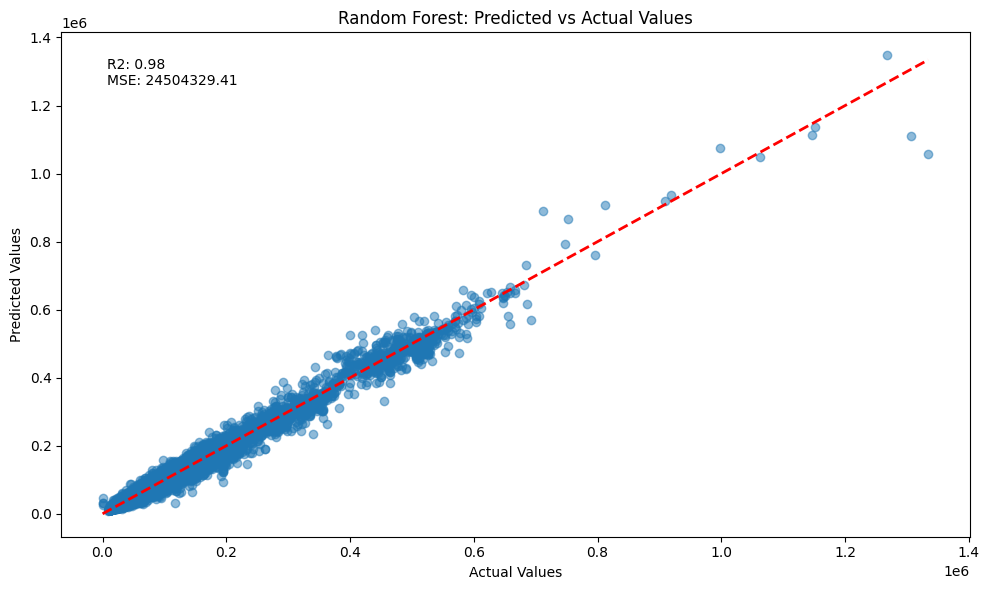

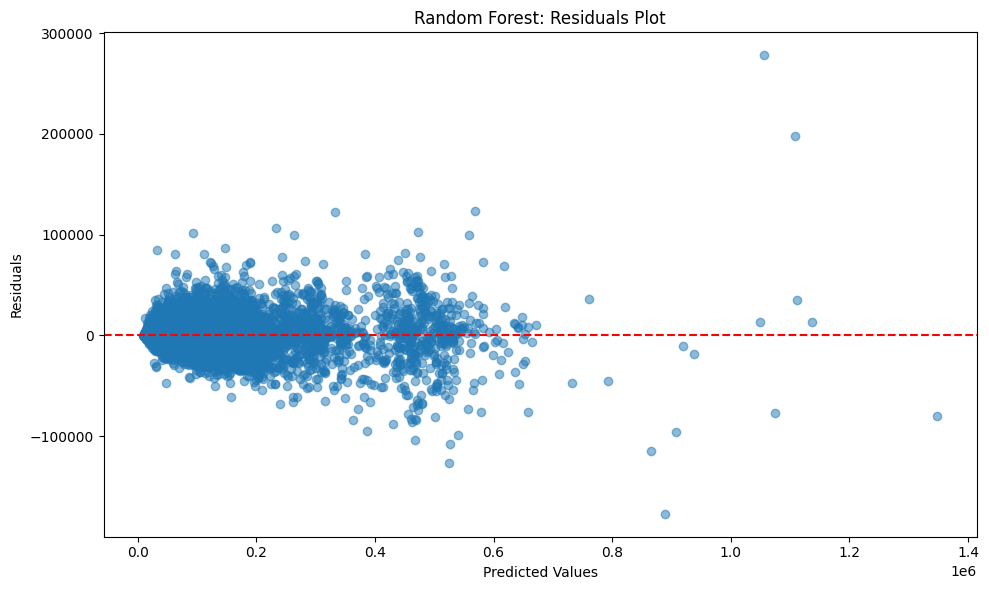

In [37]:
import matplotlib as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predicted vs Actual Values")

# Add text with metrics
plt.text(0.05, 0.95, f'R2: {r2:.2f}\nMSE: {mse:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Random Forest: Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()


In [38]:
feature_names = (numeric_features + 
                 [f"{feature}_{category}" for feature, categories in 
                  zip(categorical_features, 
                      rf_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .categories_) 
                  for category in categories[1:]])

# Get feature importances
importances = rf_model.named_steps['regressor'].feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. Distance KM (0.827806)
2. Avg_Speed (0.064027)
3. Elevation Gain (0.059600)
4. Avg_Finish_Percentage (0.021532)
5. Total Finishers (0.008740)
6. Avg_Performance_Ratio (0.008482)
7. Total_Distance (0.003279)
8. Age (0.002063)
9. Terrain_trail (0.001664)
10. Total_Races (0.001168)
11. Terrain_road (0.001102)
12. Gender_M (0.000229)


In [39]:
def generate_runner_history(data, runner_id):
    # Filter data for the specific runner
    runner_data = data[data['Runner ID'] == runner_id]
    
    if runner_data.empty:
        print(f"No data found for Runner ID: {runner_id}")
        return None
    
    # Calculate aggregate statistics
    history = {
        'avg_performance_ratio': runner_data['Performance Ratio'].mean(),
        'avg_finish_percentage': runner_data['Finish Percentage'].mean(),
        'total_races': len(runner_data),
        'total_distance': runner_data['Distance KM'].sum(),
        'preferred_terrain': runner_data['Terrain'].mode().iloc[0] if not runner_data['Terrain'].mode().empty else 'Unknown',
        #'avg_normalised_difficulty': runner_data['Normalised Difficulty Score'].mean(),
        'avg_speed': runner_data['Avg.Speed km/h'].mean(),
        'age': runner_data['Age'].iloc[-1] if 'Age' in runner_data.columns else np.nan,
        'gender': runner_data['Gender'].iloc[0] if 'Gender' in runner_data.columns else 'Unknown'
    }
    
    # Additional statistics
    history['best_performance_ratio'] = runner_data['Performance Ratio'].max()
    history['worst_performance_ratio'] = runner_data['Performance Ratio'].min()
    history['avg_elevation_gain_per_km'] = runner_data['Elevation Gain'].sum() / history['total_distance']
    history['favorite_distance'] = runner_data['Distance KM'].mode().iloc[0]
    history['avg_rank_percentage'] = runner_data['Rank'].mean() / runner_data['Total Finishers'].mean()
    
    # Calculate improvement trend (using last 5 races if available)
    last_5_races = runner_data.sort_values('Date').tail(5)
    if len(last_5_races) >= 2:
        performance_trend = np.polyfit(range(len(last_5_races)), last_5_races['Performance Ratio'], 1)[0]
        history['performance_trend'] = performance_trend
    else:
        history['performance_trend'] = 0
    
    # Handle potential NaN values
    for key, value in history.items():
        if pd.isna(value):
            if key in ['age', 'total_races', 'total_distance']:
                history[key] = 0
            elif key in ['avg_performance_ratio', 'avg_finish_percentage', 'avg_speed']:
                history[key] = data[key.replace('avg_', '')].mean()
            else:
                history[key] = 'Unknown'
    
    return history

# Example usage:
# Assuming 'data' is your DataFrame containing all race results
# runner_id = 12345  # Replace with an actual Runner ID from your dataset
# runner_history = generate_runner_history(data, runner_id)
# print(runner_history)

In [40]:
# Function to make predictions
def predict_finish_time(runner_history, race_details):
    input_data = pd.DataFrame({
        'Distance KM': [race_details['distance']],
        'Elevation Gain': [race_details['elevation_gain']], 
        'Terrain': [race_details['terrain']],
        'Total Finishers': [race_details['total_finishers']],
        #'Normalised Difficulty Score': [race_details['difficulty_score']],
        'Avg_Performance_Ratio': [runner_history['avg_performance_ratio']],
        'Avg_Finish_Percentage': [runner_history['avg_finish_percentage']],
        'Total_Races': [runner_history['total_races']],
        'Total_Distance': [runner_history['total_distance']],
        'Preferred_Terrain': [runner_history['preferred_terrain']],
        #'Avg_Normalised_Difficulty': [runner_history['avg_normalised_difficulty']],
        'Avg_Speed': [runner_history['avg_speed']],
        'Age': [runner_history['age']],
        'Gender': [runner_history['gender']]
    })
    prediction = rf_model.predict(input_data)
    return prediction[0]

In [58]:
runner_history = generate_runner_history(merged_data, '1675379')

race_details = {
    'distance': 101,
    'elevation_gain': 6050,
    'terrain': 'trail',
    'total_finishers': 1636
}

example_prediction = predict_finish_time(runner_history, race_details)
example_prediction = str(datetime.timedelta(seconds=example_prediction))
print(f"Predicted finish time: {example_prediction}")

Predicted finish time: 11:52:01.550000


In [ ]:
df_clean.columns

### Collaborative filtering

In [102]:
race_features.head()

,Runner ID,Distance,Elevation,Terrain,Speed,Date,Finishers,Distance_Bin,Elevation_Bin,Finishers_Bin
6114379,125952,46.0,920.0,trail,371.391304,2024-01-01,14,40-50km,800-1000m,0-200p
6114380,2003997,46.0,920.0,trail,382.282609,2024-01-01,14,40-50km,800-1000m,0-200p
6114381,667500,46.0,920.0,trail,382.347826,2024-01-01,14,40-50km,800-1000m,0-200p
6114382,1871505,46.0,920.0,trail,382.521739,2024-01-01,14,40-50km,800-1000m,0-200p
6114383,2124691,46.0,920.0,trail,421.521739,2024-01-01,14,40-50km,800-1000m,0-200p


In [141]:
from sklearn.cluster import KMeans

df_collab = df_clean[df_clean['Elevation Gain'].notna()]

# Step 2: Extract relevant features
def extract_features(row):
    return pd.Series({
        'Runner ID': row['Runner ID'],
        'Distance': row['Distance KM'],
        'Elevation': row['Elevation Gain'],
        'Terrain': row['Terrain'],
        #'Time': row['Time Seconds Finish'],
        'Speed': row['Average Speed'],
        'Date': row['Date'],  # Include date to differentiate between races
        'Finishers': row['Total Finishers']
    })

race_features = df_collab.apply(extract_features, axis=1)

# Step 3: Create bins for distance and elevation
def create_distance_bin(distance):
    return f"{int(distance // 10 * 10)}-{int((distance // 10 + 1) * 10)}km"

def create_elevation_bin(elevation):
    return f"{int(elevation // 200 * 200)}-{int((elevation // 200 + 1) * 200)}m"

def create_finishers_bin(finishers):
    return f"{int(finishers // 200 * 200)}-{int((finishers // 200 + 1) * 200)}"

race_features['Distance_Bin'] = race_features['Distance'].apply(create_distance_bin)
race_features['Elevation_Bin'] = race_features['Elevation'].apply(create_elevation_bin)
race_features['Finishers_Bin'] = race_features['Finishers'].apply(create_finishers_bin)

# Step 4: Encode categorical variables
categorical_columns = ['Terrain', 'Distance_Bin', 'Elevation_Bin', 'Finishers_Bin']
race_features_encoded = pd.get_dummies(race_features, columns=categorical_columns)

# Step 5: Standardize numerical features
scaler = StandardScaler()
numerical_features = ['Distance', 'Elevation', 'Finishers']
race_features_encoded[numerical_features] = scaler.fit_transform(race_features_encoded[numerical_features])

# Step 6: Cluster races
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_features = race_features_encoded.drop(['Runner ID', 'Speed', 'Date'], axis=1)
race_features_encoded['Cluster'] = kmeans.fit_predict(clustering_features)

#dbscan = DBSCAN(eps=0.5, min_samples=5)
#clustering_features = race_features_encoded.drop(['Runner ID', 'Time', 'Date'], axis=1)
#race_features_encoded['Cluster'] = dbscan.fit_predict(clustering_features)

In [142]:
race_features_encoded.head()

,Runner ID,Distance,Elevation,Speed,Date,Finishers,Terrain_other,Terrain_road,Terrain_track,Terrain_trail,...,Finishers_Bin_1600-1800,Finishers_Bin_1800-2000,Finishers_Bin_200-400,Finishers_Bin_2000-2200,Finishers_Bin_2200-2400,Finishers_Bin_2600-2800,Finishers_Bin_400-600,Finishers_Bin_600-800,Finishers_Bin_800-1000,Cluster
6114379,125952,-0.783908,-0.957768,371.391304,2024-01-01,-0.889026,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24
6114380,2003997,-0.783908,-0.957768,382.282609,2024-01-01,-0.889026,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24
6114381,667500,-0.783908,-0.957768,382.347826,2024-01-01,-0.889026,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24
6114382,1871505,-0.783908,-0.957768,382.521739,2024-01-01,-0.889026,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24
6114383,2124691,-0.783908,-0.957768,421.521739,2024-01-01,-0.889026,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24


In [143]:
# Step 7: Create User-Item Matrix
def create_user_item_matrix(df):
    # Group by Runner ID and Cluster, then aggregate
    grouped = df.groupby(['Runner ID', 'Cluster'])
    
    # Calculate statistics for each runner-cluster combination
    agg_data = grouped.agg({
        'Speed': ['count', 'mean', 'min', 'max', 'std']
    })
    
    # Flatten column names
    agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
    
    # Unstack the DataFrame to create the matrix
    user_item_matrix = agg_data.unstack(level='Cluster')
    
    # Flatten column names again
    user_item_matrix.columns = [f'{stat}_{cluster}' for stat, cluster in user_item_matrix.columns]
    
    return user_item_matrix

user_item_matrix = create_user_item_matrix(race_features_encoded)

# Print some information about the user-item matrix
print("User-Item Matrix Shape:", user_item_matrix.shape)
print("\nFirst few rows of the User-Item Matrix:")
print(user_item_matrix.head())
print("\nNumber of unique runners:", user_item_matrix.index.nunique())
print("Number of features per cluster:", len(user_item_matrix.columns) // n_clusters)

# Optional: Fill NaN values
user_item_matrix = user_item_matrix.fillna(0)

# Now you have a user-item matrix where each cell contains multiple statistics
# about a runner's performance in a particular race cluster

User-Item Matrix Shape: (175792, 250)

First few rows of the User-Item Matrix:
           Speed_count_0  Speed_count_1  Speed_count_2  Speed_count_3  \
Runner ID                                                               
1000030              NaN            NaN            NaN            NaN   
1000046              1.0            NaN            NaN            NaN   
1000050              NaN            NaN            NaN            NaN   
1000073              NaN            NaN            NaN            NaN   
1000084              NaN            NaN            NaN            NaN   

           Speed_count_4  Speed_count_5  Speed_count_6  Speed_count_7  \
Runner ID                                                               
1000030              NaN            NaN            NaN            NaN   
1000046              NaN            NaN            NaN            NaN   
1000050              NaN            NaN            NaN            NaN   
1000073              NaN            NaN     

In [144]:
# Step 8: Implement Collaborative Filtering
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare the data
X = user_item_matrix.values
runner_ids = user_item_matrix.index

# Split the data into training and testing sets
X_train, X_test, runner_ids_train, runner_ids_test = train_test_split(X, runner_ids, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Perform matrix factorization
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_factorized = svd.fit_transform(X_train_imputed)


In [145]:
# Step 9: Make predictions
def predict_times(X_factorized, svd_model):
    return np.dot(X_factorized, svd_model.components_)

X_train_pred = predict_times(X_train_factorized, svd)
X_test_factorized = svd.transform(X_test_imputed)
X_test_pred = predict_times(X_test_factorized, svd)

# Step 10: Evaluate the model
def evaluate_predictions(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Evaluate on training set
train_mae, train_rmse, train_r2 = evaluate_predictions(X_train_imputed, X_train_pred)
print(f"Training MAE: {train_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training R2: {train_r2:.2f}")

# Evaluate on test set
test_mae, test_rmse, test_r2 = evaluate_predictions(X_test_imputed, X_test_pred)
print(f"Test MAE: {test_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Training MAE: 0.05
Training RMSE: 2.04
Training R2: 0.84
Test MAE: 0.05
Test RMSE: 2.18
Test R2: 0.84


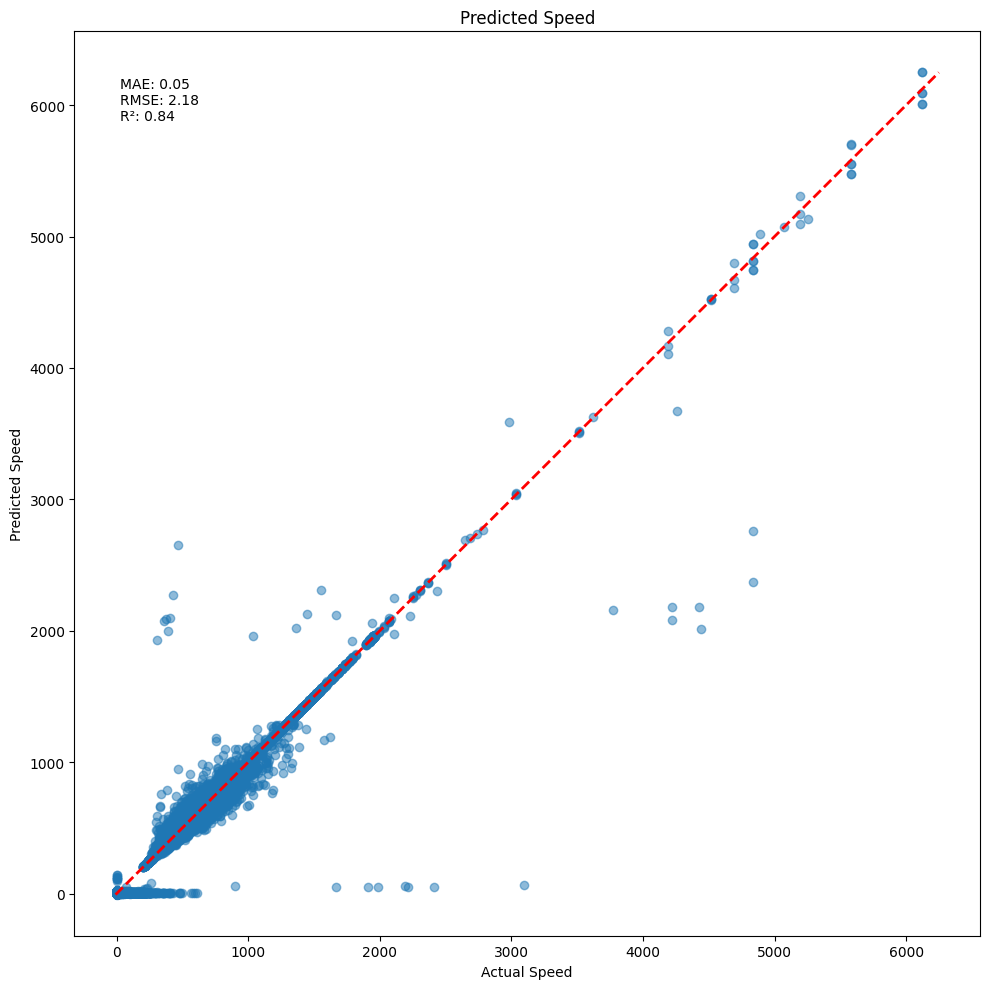

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(X_train_imputed, X_train_pred, alpha=0.5)

# Add perfect prediction line
max_value = max(np.max(X_train_imputed), np.max(X_train_pred))
min_value = min(np.min(X_train_imputed), np.min(X_train_pred))
plt.plot([min_value, max_value], [min_value, max_value], 'r--', lw=2)

plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Predicted Speed')

# Add metrics to the plot
plt.text(0.05, 0.95, f'MAE: {test_mae:.2f}\nRMSE: {test_rmse:.2f}\nR²: {test_r2:.2f}', 
            transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

In [147]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def get_race_cluster(distance, elevation, terrain, finishers):
    # Create a DataFrame for the new race
    new_race = pd.DataFrame({
        'Distance': [distance],
        'Elevation': [elevation],
        'Terrain': [terrain],
        'Finishers': [finishers]
        #'Country': [country]
    })
    
    # Create bins for distance and elevation
    new_race['Distance_Bin'] = new_race['Distance'].apply(create_distance_bin)
    new_race['Elevation_Bin'] = new_race['Elevation'].apply(create_elevation_bin)
    new_race['Finishers_Bin'] = new_race['Finishers'].apply(create_finishers_bin)
    
    # Get all possible columns from the training data
    all_columns = clustering_features.columns.tolist()
    
    # Prepare the data for encoding
    data_to_encode = new_race[['Terrain', 'Distance_Bin', 'Elevation_Bin', 'Finishers_Bin']]
    
    # Perform one-hot encoding
    encoded_cols = pd.get_dummies(data_to_encode)
    
    # Create a DataFrame with all columns from training data, filled with zeros
    new_race_encoded = pd.DataFrame(0, index=new_race.index, columns=all_columns)
    
    # Update the values for the columns that are present in the encoded data
    for col in encoded_cols.columns:
        if col in new_race_encoded.columns:
            new_race_encoded[col] = encoded_cols[col]
    
    # Add 'Distance' and 'Elevation' columns
    new_race_encoded['Distance'] = new_race['Distance']
    new_race_encoded['Elevation'] = new_race['Elevation']
    new_race_encoded['Finishers'] = new_race['Finishers']
    
    # Ensure the order of columns matches the training data
    new_race_encoded = new_race_encoded[clustering_features.columns]
    
    # Standardize numerical features
    numerical_features = ['Distance', 'Elevation', 'Finishers']
    new_race_encoded[numerical_features] = scaler.transform(new_race_encoded[numerical_features])
    
    # Predict the cluster
    cluster = kmeans.predict(new_race_encoded)[0]
    
    return cluster

def predict_for_new_race(runner_id, distance, elevation, terrain, finishers, stat='mean'):
    if runner_id not in user_item_matrix.index:
        print(f"Runner {runner_id} not found in the dataset.")
        return None, None
    
    race_cluster = get_race_cluster(distance, elevation, terrain, finishers)
    
    # Diagnostic information
    print(f"Predicted cluster: {race_cluster}")
    #print(f"Number of clusters in KMeans model: {kmeans.n_clusters_}")
    print(f"Unique clusters in user-item matrix: {sorted(set([int(col.split('_')[-1]) for col in user_item_matrix.columns if f'Time_{stat}_' in col]))}")
    
    runner_features = user_item_matrix.loc[runner_id].values.reshape(1, -1)
    runner_features_imputed = imputer.transform(runner_features)
    runner_factorized = svd.transform(runner_features_imputed)
    predictions = predict_times(runner_factorized, svd)
    
    column_name = f'Speed_{stat}_{race_cluster}'
    if column_name not in user_item_matrix.columns:
        print(f"No data available for Speed_{stat} in cluster {race_cluster}")
        
        # Find the nearest available cluster
        available_clusters = [int(col.split('_')[-1]) for col in user_item_matrix.columns if f'Speed_{stat}_' in col]
        if not available_clusters:
            print(f"No clusters found for Speed_{stat}")
            return None, race_cluster
        nearest_cluster = min(available_clusters, key=lambda x: abs(x - race_cluster))
        print(f"Using nearest available cluster: {nearest_cluster}")
        
        column_name = f'Speed_{stat}_{nearest_cluster}'
    
    cluster_index = user_item_matrix.columns.get_loc(column_name)
    predicted_time = predictions[0, cluster_index]
    
    return predicted_time, race_cluster


In [148]:
# Example usage
runner_id = '1393329'
new_race_distance = 101  # km
new_race_elevation = 6050  # meters
new_race_terrain = 'trail'
new_race_finishers = 1636

predicted_speed, assigned_cluster = predict_for_new_race(runner_id, new_race_distance, new_race_elevation, new_race_terrain, new_race_finishers)
predicted_time = predicted_speed * new_race_distance
predicted_time = str(datetime.timedelta(seconds=predicted_time))

if predicted_time is not None:
    print(f"New race assigned to cluster: {assigned_cluster}")
    print(f"Predicted mean time for runner {runner_id}: {predicted_time} seconds")
else:
    print("Unable to make a prediction.")

# You can also predict min, max, or other stats by changing the 'stat' parameter
predicted_min_speed, _ = predict_for_new_race(runner_id, new_race_distance, new_race_elevation, new_race_terrain, new_race_finishers, stat='min')
predicted_min_time = predicted_min_speed * new_race_distance
predicted_min_time = str(datetime.timedelta(seconds=predicted_min_time))

if predicted_min_time is not None:
    print(f"Predicted minimum time for runner {runner_id}: {predicted_min_time} seconds")

Predicted cluster: 15
Unique clusters in user-item matrix: []
New race assigned to cluster: 15
Predicted mean time for runner 1393329: 0:00:00.000946 seconds
Predicted cluster: 15
Unique clusters in user-item matrix: []
Predicted minimum time for runner 1393329: 0:00:00.000946 seconds
